# CS 230 Content Moderation Project #
*by: Guy Wuollete, Martin Amethier, Isabella Garcia-Camargo*

In [2]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import string
import datetime
import re
%load_ext autoreload
%autoreload 2

#modeling imports
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline
plt.style.use('fivethirtyeight')

#tf imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support, classification_report, accuracy_score


#multinomial nb
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from scipy.sparse.linalg import svds



In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
subm = pd.read_csv('./data/sample_submission.csv')
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[labels].max(axis=1) #make an indicator for when there is no 
                                            #value for any of the labels 
#cant have any of the unknown values 
train['comment_text'].fillna("unknown", inplace=True)
test['comment_text'].fillna("unknown", inplace=True)

In [4]:
def load_data():

    data = os.path.join("data", "train.csv")

    df = pd.read_csv(data)
    X_train = df[['id', 'comment_text']]
    y_train = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

    X_test = pd.read_csv(os.path.join("data", "test.csv"))
    y_test = pd.read_csv(os.path.join("data", "test_labels.csv"))
    test = X_test.merge(y_test, on='id')
    test = test[ (test['toxic']!=-1) | (test['severe_toxic']!=-1) | 
                (test['obscene']!=-1) | (test['threat']!=-1) | (test['insult']!=-1) 
                | (test['identity_hate']!=-1) ]
    test = test.reset_index(drop=True) 
    
    X_test = test[['id', 'comment_text']]
    y_test = test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

    return X_train, y_train, X_test, y_test 

In [5]:
X_train, y_train, X_test, y_test = load_data()

# Visualizations

The Mean Comment Length is:  394.0732213246768


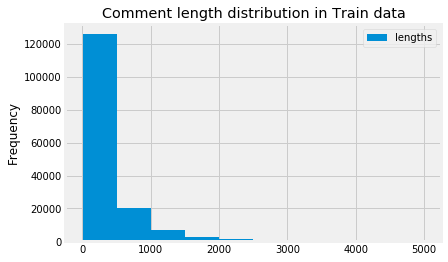

In [40]:
X_train['lengths'] = X_train['comment_text'].apply(lambda x : len(x))
X_train.head()

X_train.plot.hist(title = 'Comment length distribution in Train data')
print("The Mean Comment Length is: ", np.mean(X_train['lengths']))

toxic           0.095844
severe_toxic    0.009996
obscene         0.052948
threat          0.002996
insult          0.049364
dtype: float64

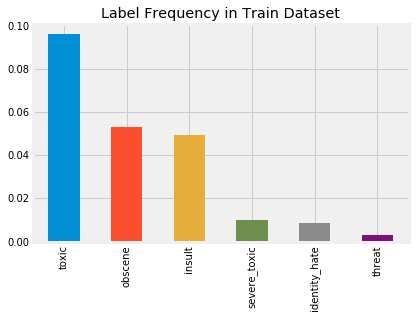

In [42]:
counts = y_train.mean(axis=0)
counts.sort_values(ascending=False).plot.bar(title='Label Frequency in Train Dataset')
counts.head()

# Naive Bayes SVM Baseline

In [67]:
#tokenizing stuff 
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize_vals(s): return re_tok.sub(r' \1 ', s).split()

In [68]:
n = train.shape[0]
#creating our vectorizer
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize_vals,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

In [69]:
#fit each of the train, test to get tfidf scores for each of the docs. 
x_train_term = vec.fit_transform(X_train['comment_text'])
x_test_term = vec.transform(X_test['comment_text'])
x_train_term, x_test_term

(<159571x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 17775104 stored elements in Compressed Sparse Row format>,
 <63978x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 6506557 stored elements in Compressed Sparse Row format>)

In [70]:
#BAYESIAN feature equation
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [71]:
x = x_train_term
test_x = x_test_term

In [72]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True) 
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [73]:
preds = np.zeros((len(X_test), len(labels)))

for i, j in enumerate(labels):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic


/Users/Isabella_GC/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


fit severe_toxic


/Users/Isabella_GC/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit obscene


/Users/Isabella_GC/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit threat


/Users/Isabella_GC/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit insult


/Users/Isabella_GC/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit identity_hate


/Users/Isabella_GC/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [74]:
df = pd.DataFrame(preds, columns=labels)

In [75]:
#for each column, if over threshold value of .5 predict 1, otherwise 0
predict = df.apply(lambda x: x >= .5, 1, 0)

/Users/Isabella_GC/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The broadcast argument is deprecated and will be removed in a future version. You can specify result_type='broadcast' to broadcast the result to the original dimensions
  


In [76]:
precision, recall, fbeta_score, support = \
    precision_recall_fscore_support(y_test, predict)
accuracy = accuracy_score(y_test, predict)

print ("Accuracy {}\n".format(accuracy))

print (classification_report(y_test, predict))

# return (precision, recall, fbeta_score, support, accuracy)

Accuracy 0.8898683922598393

              precision    recall  f1-score   support

           0       0.62      0.78      0.69      6090
           1       0.36      0.35      0.35       367
           2       0.72      0.68      0.70      3691
           3       0.62      0.35      0.45       211
           4       0.75      0.54      0.63      3427
           5       0.71      0.31      0.43       712

   micro avg       0.66      0.66      0.66     14498
   macro avg       0.63      0.50      0.54     14498
weighted avg       0.67      0.66      0.65     14498
 samples avg       0.07      0.06      0.06     14498



/Users/Isabella_GC/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/Users/Isabella_GC/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
